# Python Demo For All-GRAD Meetup 

#### Michael Smith,  May, 2016

## Intro

This notebook is to serve as a demonstration of a real use-case for Python and some of it's common data science packages.  In helping prepare analysis to be used in Nielsen's presentation for the POI Conference, I leveraged Python to do some of the repeatable analysis so that I could produce results quickly and in an easily repeatable method.  The class I built is called 'benchmark' and it includes the following functions:

    - read_data:  Takes a csv file and converts it to a pandas dataframe
    - find_roi:  Caluclates ROI given an aggregation classifier and a year
    - find_coeff:  Prepares requested coefficients from Norms models
    - coeff_roi_reg:  Plots ROI vs a requested norms coefficient and the trendline and gives the regression equation and R^2
    - elast_clustering:  Runs K-Means analysis for a given Norms coefficient against ROI for n clusters (n : [1,6]) 
        and gives both the plot of resulting clusters and returns the labeling in a dataframe

## Using an IPython Notebook:
This notebook is made up of cells.  There are two types within this particular notebook:  markdown (like this one) and code (those with "In []" next to them).  To run a cell of code, click inside that cell and press Shift+Enter.  This runs the cell and places you within the next cell.

## Package selection
First we pull in the required packages for handling datasets and analyzing data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.mpl
import bokeh.plotting
from sklearn.cluster import KMeans
bokeh.io.output_notebook()

%load_ext watermark

Loading BokehJS ...

## Notebook Options
These are specific for the IPython (Jupyter) notebook environment.

The first, '%matplotlib inline', dictates that any plots will be rendered inline with the cells in this notebook.

The second is a package, '%watermark' which keeps track of versions of Python and packages being used within this notebook.  It is helpful and good practice to track this information for reproducibility.


In [2]:
%matplotlib inline
%watermark -v -m -p pandas,numpy,statsmodels,matplotlib

CPython 3.5.1
IPython 4.1.2

pandas 0.18.0
numpy 1.10.4
statsmodels 0.6.1
matplotlib 1.5.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 8.1
machine    : AMD64
processor  : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores  : 4
interpreter: 64bit


## Creating the Benchmarks class.
Below is the major chunk of code where I define the class and functions within it.  You can see the basic structure very easily by following the indention structure.

    Class
        function 1(options):
            code
        
        ...
        
        function n(options):
            code

Running this cell of code will 'initialize' the class and make it available throughout the rest of the python session.

In [40]:
class benchmark(object):
    """Class for doing some analysis for POI Conference Presentation"""
    
    def read_data(csv_path):
        """Reads in data which is already merged in the form
           Benchmark data aggregated by country,year,category,roi range followed by
           model coefficients from Core Models"""
        
        try:
            data = pd.read_csv(csv_path)
            data.columns = ['category', 'year','market_channel', 'department',
                'roi_range', 'value', 'baseline_value', 'trade_spend_total',
                'trade_spend_incl_cogs', 'number_of_tpr_weeks',
                'number_of_display_weeks', 'number_of_feature_weeks',
                'number_of_event_weeks', 'mfr_roi_value', 'trade_direct_promo_spend',
                'number_of_weeks','number_of_records', 'PPI', 'BP', 'FEDI', 'DISO',
                'FEAO']
            
        except ValueError:
            print('File is either unavailable or non-existent.')
        
        return data

    def find_roi(in_data,agg_var='category',year=2015):
        """Calculates ROI for a Benchmark dataset given a level of aggregation and year"""
        
        roi_data = in_data[[agg_var,'year','roi_range','mfr_roi_value','trade_direct_promo_spend']]
        roi_data = roi_data[(roi_data.year==year) & (roi_data.roi_range.notnull())]
        roi_pivot = pd.pivot_table(roi_data,values=['mfr_roi_value','trade_direct_promo_spend'], 
                                   index=[agg_var],aggfunc='sum')

        roi_pivot['roi'] = (roi_pivot['mfr_roi_value']/roi_pivot['trade_direct_promo_spend']) + 1
        
        return roi_pivot.drop(roi_pivot.columns[[0,1]],axis=1)
        
    def find_coeff(in_data,agg_var='category',coeff='PPI'):
        """Compiles requested Norms coefficient given an aggregation level"""
        
        return pd.pivot_table(in_data,values=[coeff],index=[agg_var],aggfunc='mean')
        
    def graph(formula,x_range):
        """Helper function for graphing a line equation"""
        
        x = np.array(x_range)
        y = eval(formula)
        plt.plot(x,y)
        
    def coeff_roi_reg(in_data,agg_var,year,norms_coeff,path='none',interactive='False'):
        """Plots ROI vs given Norms coefficient and plots the regression line.  Output is a plot
           with the line, the equation, and the R-Squared included"""
        
        coeff_roi_data = pd.merge(benchmark.find_roi(in_data,agg_var,year),
                                  benchmark.find_coeff(in_data,agg_var,norms_coeff),
                                  left_index=True, right_index=True)
        coeff_roi_data = coeff_roi_data[coeff_roi_data['roi'].notnull() & coeff_roi_data[norms_coeff].notnull()]
        
        roi = coeff_roi_data['roi']
        
        coeff = sm.add_constant(coeff_roi_data[norms_coeff])
        
        model = sm.OLS(roi,coeff)
        results = model.fit()
        #find equation for graph
        intercept = round(results.params[0],3)
        coeff_effect = round(results.params[1],3)
        trendline = str(intercept)+'+x*'+str(coeff_effect)
        r2 = round( results.rsquared, 3)
        
        plt.plot(coeff[norms_coeff],roi,'o')
        
        benchmark.graph(trendline,coeff[norms_coeff])
        
        plt.xlabel(norms_coeff)
        plt.ylabel('ROI')
        plt.title('Promo ROI vs ' + norms_coeff + ' by ' + agg_var + ' - ' + str(year))        
        plt.text(min(coeff[norms_coeff]),max(roi)-.15,'ROI ~ ' + str(intercept) + str(coeff_effect) + '*' + norms_coeff 
                 + '\n' + 'R-Squared: '+str(r2))
        if(path=='none'):
            if(interactive):
                bokeh.plotting.show(bokeh.mpl.to_bokeh())
            else:
                plt.show()
        else:
            plt.savefig(path)
    
    def elast_clustering(in_data,norms_coeff,year,clusters,interactive=False):
        """Runs K-Means analysis for a given Norms coefficient against ROI for n clusters (n : [1,6]) 
            and gives both the plot of resulting clusters and returns the labeling in a dataframe"""
        
        coeff_roi_data = pd.merge(benchmark.find_roi(in_data,'category',year),
                                  benchmark.find_coeff(in_data,'category',norms_coeff),
                                  left_index=True, right_index=True)
        coeff_roi_data = coeff_roi_data[coeff_roi_data['roi'].notnull() & coeff_roi_data[norms_coeff].notnull()]
        
        colors = ['#4EACC5', '#FF9C34', '#4E9A06','#E9461E','#8B008B','#808080']        
        
        kmeans = KMeans(n_clusters=clusters)
        kmeans.fit(coeff_roi_data)
        k_means_labels = kmeans.labels_
        k_means_cluster_centers = kmeans.cluster_centers_
        
        
        for k in range(clusters):
            my_members = k_means_labels == k
            cluster_center = k_means_cluster_centers[k]
            plt.plot(coeff_roi_data[norms_coeff][my_members],coeff_roi_data['roi'][my_members],'w',
                     markerfacecolor = 'none', markeredgecolor = colors[k], marker='o')
            plt.plot(cluster_center[1], cluster_center[0], 'o',
                      markerfacecolor=colors[k], markersize=8)
        
        plt.xlabel(norms_coeff)
        plt.ylabel('ROI')
        plt.title('K-Means Nearest Neighbors with ' + str(clusters) + ' Clusters.' + ' - ' + str(year))
        
        if(interactive):
            bokeh.plotting.show(bokeh.mpl.to_bokeh())
        else:
            plt.show()
        
        coeff_roi_data['label'] = k_means_labels
        
        return coeff_roi_data

## Using the Benchmark class
Now that we have these tools created, we can begin using them to produce analysis easily.

Let's first read in the sample dataset.  I created a method to read in the csv and name the columns from a less-intuitive NDX fact name to something that makes more sense.  

The data contains benchmark data aggregated to year, category, and range of event success (no event, lost money, broke even, made money).  It also contains category-aggregated coefficients from the Norms models.  

In [9]:
data = benchmark.read_data('new_sample_in.csv')
data[1:6]

,category,year,market_channel,department,roi_range,value,baseline_value,trade_spend_total,trade_spend_incl_cogs,number_of_tpr_weeks,...,number_of_event_weeks,mfr_roi_value,trade_direct_promo_spend,number_of_weeks,number_of_records,PPI,BP,FEDI,DISO,FEAO
1,ABRASIVE CLEANING PADS,2013,Hyper+Super Markets,HOMECARE,0-1,3.048208e+06,2.269772e+06,1.381954e+06,472021.548500,19026,...,19192,-201899.707700,9.099320e+05,19192,7684,-1.777741,-0.978951,0.584786,0.392526,0.299189
2,ABRASIVE CLEANING PADS,2013,Hyper+Super Markets,HOMECARE,<0,2.512597e+04,3.842004e+04,8.109991e+02,-2627.485807,168,...,195,-7379.713642,3.438485e+03,195,164,-1.777741,-0.978951,0.584786,0.392526,0.299189
3,ABRASIVE CLEANING PADS,2013,Hyper+Super Markets,HOMECARE,>1,3.501021e+06,1.237581e+06,1.922708e+06,886389.769100,13950,...,14090,293266.400600,1.036318e+06,14090,6218,-1.777741,-0.978951,0.584786,0.392526,0.299189
4,ABRASIVE CLEANING PADS,2014,Hyper+Super Markets,HOMECARE,NaN,3.154147e+07,3.030705e+07,3.887507e+05,388750.705700,0,...,0,0.000000,0.000000e+00,586613,8754,-1.777741,-0.978951,0.584786,0.392526,0.299189
5,ABRASIVE CLEANING PADS,2014,Hyper+Super Markets,HOMECARE,0-1,3.149330e+06,2.384637e+06,1.375413e+06,464836.492000,19324,...,19449,-213321.617900,9.105764e+05,19449,7588,-1.777741,-0.978951,0.584786,0.392526,0.299189


## Promotion Coefficients vs ROI
My initial questions were about the relationship between promotion ROI and various Core model coefficients.  Using my method 'coeff_roi_reg', I can easily specify the dataset to be used, whether I want to aggregate by department or by category, and which coefficient I want to compare to ROI. 

I'm able to make multiple calls easily over a list of strings in a loop to look for potential relationships.

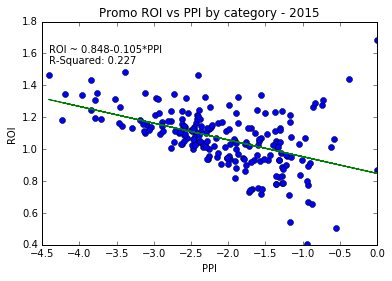

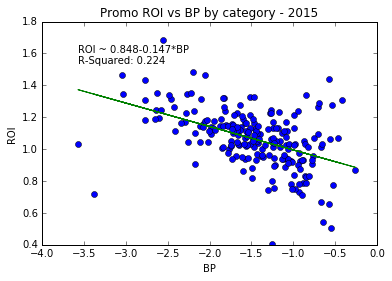

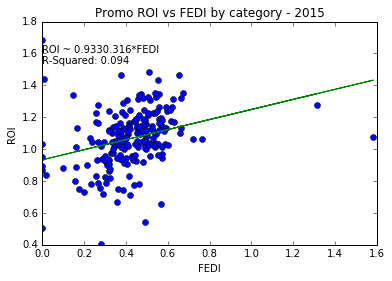

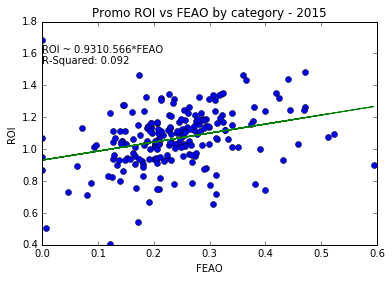

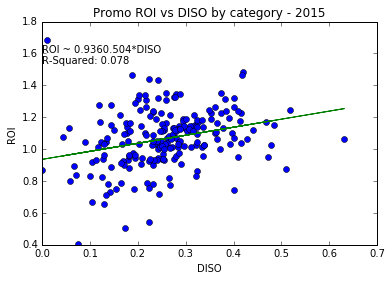

In [12]:
for coeff in ['PPI','BP','FEDI','FEAO','DISO']:
    benchmark.coeff_roi_reg(data,'category',2015,coeff,interactive=False)

## PPI vs ROI Over Time

Looking at the above, PPI (promoted price elasticity) seems to have a fairly strong relationship with ROI.  Next, I'm curious to see how that may be changing over time.  We can do this simply by looping over the available years in the data with a constant coefficient selection.

In [13]:
for year in np.unique(data['year']):
    benchmark.coeff_roi_reg(data,'category',year,'PPI',interactive=True)    

We can see that the relationship gets slightly weaker over time and the effect dampens slightly as well.

## Elasticity Clustering

With this knowledge of an existing relationship between PPI and ROI, I wanted to see if I could break the relationship into meaninful clusters of categories.  For example:  "High Return, High Elasticity" vs "Low Return, Low Elasticity".  To do this, I use the K-Means module from the Sci-Kit Learn package within a module I created called 'elast_clustering'.  By simply calling the method, we get a plot of the nearest-neighbor clustering.  I loop through various cluster numbers.

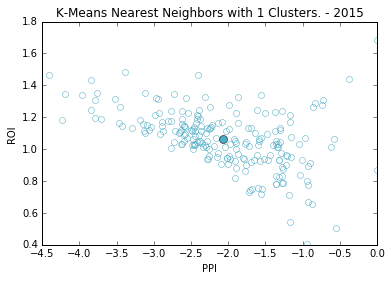

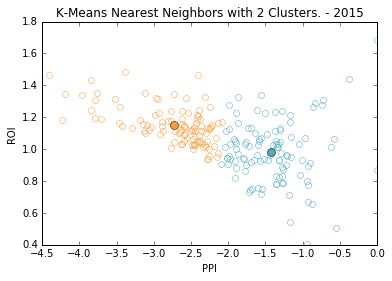

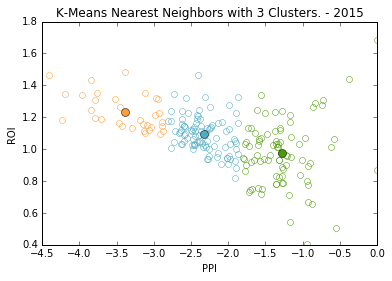

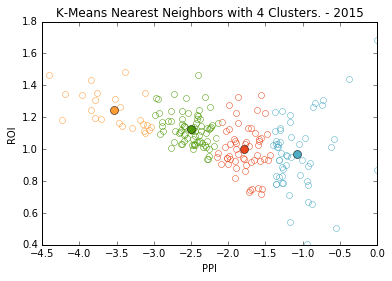

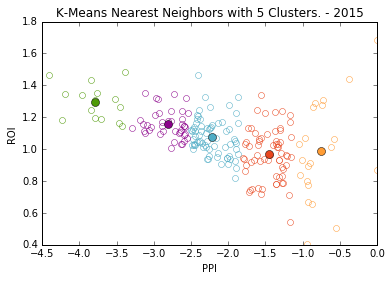

In [41]:
for n in range(1,6):
    benchmark.elast_clustering(data,'PPI',2015,n)

## Output Clustering Labels

The method, if assigned to a variable, will return a Dataframe of categories, their ROI, coefficient value, and the labeling output from the K-Means cluster assignments.  We could then create a .csv output file with the labels to share or use in further analysis. Pandas Dataframes have a method to do this called .to_csv().

In [43]:
labeled_data = benchmark.elast_clustering(data,'PPI',2015,3,interactive=True)
print(labeled_data.sort_values('PPI'))

labeled_data.to_csv('labeled_data_out.csv')

                                roi       PPI  label
category                                            
OILS EDIBLE                1.462227 -4.412878      1
TOMATOES AMBIENT           1.183401 -4.236400      1
BEER                       1.346791 -4.187824      1
SWEET SPREADS              1.337319 -3.959932      1
FISH FROZEN                1.244848 -3.849671      1
WHISKY                     1.433981 -3.838645      1
COFFEE                     1.308708 -3.792956      1
KITCHEN TOWELS             1.193390 -3.788503      1
SPARKLING WINE             1.350308 -3.757178      1
TOILET PAPER               1.188994 -3.712158      1
FISH AMBIENT               1.311622 -3.523927      1
PIZZA FROZEN               1.160962 -3.469891      1
FABRIC SOFTENERS           1.263335 -3.449120      1
DRY PASTA                  1.143575 -3.421883      1
CHAMPAGNE                  1.486496 -3.392655      1
PAPER NAPKINS              1.132696 -3.297414      1
SWEET BISCUITS             1.180344 -3.184644 